In [46]:
import sys
import json
import polars as pl
import uuid
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import folium
import sqlite3
from pathlib import Path
from sqlalchemy import create_engine, MetaData
from sqlalchemy_schemadisplay import create_schema_graph
from IPython.display import Image, display

# Installation instructions
# This is probably not fully complete but comes close. I've ran out of time

# !{sys.executable} -m pip install -U polars "plotly[kaleido]" folium sqlalchemy sqlalchemy_schemadisplay pydot graphviz
# On your Mac, you also need to install graphviz via: brew install graphviz

USER_SETTINGS = {
    'user_needs_to_print': True #Set to False for getting the interactive visualizations for the notebook
}

# My approach

It's much more fun, and for quick prototyping purposes it makes more sense to gather the data first ASAP.

Then, once that's done, put it in a dataframe in such a way that if a SQL database is necessary, it can be quickly converted to one.

Once it's in a dataframe, we can analyze it and visualize it.

Finally, if we have time left, we can put it in a database.

Why do it this way and not do the questions in order? Because this is the quickest way to analyze the data while still being clear on upgrading storage later on.

So it's a bit more of an iterative approach.

# Data prep

I'm polling the buienradar API every 5 minutes. I just want to make sure I have all the data, so I need to clean it first by deduplicating it.

I'm keeping it simple by using a string comparison.

In [47]:
with open('buienradar.ndjson') as f:
    raw_data: str = [line for line in f]


if not USER_SETTINGS['user_needs_to_print']:
    raw_data

In [48]:
data = [json.loads(line) for line in list(set(raw_data))]

if not USER_SETTINGS['user_needs_to_print']:
    raw_data

# Part 1: Data Integration

## Question 1: Create a dataset with the following information about the weather station measurements.

```
measurementid (not in dataset by default)
timestamp
temperature
groundtemperature
feeltemperature
windgusts
windspeedBft
humidity
precipitation
sunpower
stationid
```

## Question 2: Create a dataset with the information about the weather stations:

```
stationid
stationname
lat
lon
regio
```

In [49]:
# output ommitted for printing
# data[0]['actual']['stationmeasurements'][0]

## A scratchpad to map the JSON to a polars dataframe.

If you're wondering: why polars? Polars is a lot like SQL, so by simply exploring it with polars, the SQL becomes clear too.

This is just a scratchpad so I can quickly see how the JSON data maps to what is asked.

*weather station measurements*
* measurementid (not in dataset by default)
* timestamp
* temperature
* groundtemperature
* feeltemperature
* windgusts
* windspeedBft
* humidity
* precipitation
* sunpower
* stationid

```
{
     '$id': '4',
     'stationid': 6391,
     'stationname': 'Meetstation Arcen',
     'lat': 51.5,
     'lon': 6.2,
     'regio': 'Venlo',
     'timestamp': '2025-08-24T19:20:00',
     'weatherdescription': 'Zwaar bewolkt',
     'iconurl': 'https://cdn.buienradar.nl/resources/images/icons/weather/30x30/c.png',
     'fullIconUrl': 'https://cdn.buienradar.nl/resources/images/icons/weather/96x96/C.png',
     'graphUrl': 'https://www.buienradar.nl/nederland/weerbericht/weergrafieken/c',
     'winddirection': 'N',
     'temperature': 20.0,
     'groundtemperature': 19.8,
     'feeltemperature': 20.0,
     'windgusts': 3.9,
     'windspeed': 2.2,
     'windspeedBft': 2,
     'humidity': 41.0,
     'precipitation': 0.0,
     'sunpower': 46.0,
     'rainFallLast24Hour': 0.0,
     'rainFallLastHour': 0.0,
     'winddirectiondegrees': 349
}
```

weather stations:
* stationid
* stationname
* lat
* lon
* regio

In [50]:
# Let's create the station_measurements_df and make it look like an SQL table by also creating an extra ID.
# I want the ID to reflect information on which measurement group it was in. For this I use a uuid.

all_measurements = []
for record_idx, record in enumerate(data):
    group_id = str(uuid.uuid4())
    for station in record['actual']['stationmeasurements']:
        measurement = {
            'measurementid': f"{group_id}_{station['stationid']}",
            'timestamp': station.get('timestamp'),
            'temperature': station.get('temperature'),
            'groundtemperature': station.get('groundtemperature'),
            'feeltemperature': station.get('feeltemperature'),
            'windgusts': station.get('windgusts'),
            'windspeedBft': station.get('windspeedBft'),
            'humidity': station.get('humidity'),
            'precipitation': station.get('precipitation'),
            'sunpower': station.get('sunpower'),
            'stationid': station.get('stationid')
        }
        all_measurements.append(measurement)

station_measurements_df = pl.DataFrame(all_measurements).with_columns([
    pl.col('measurementid'),
    pl.col('timestamp').str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S"),
    pl.col('temperature').cast(pl.Float32),
    pl.col('groundtemperature').cast(pl.Float32),
    pl.col('feeltemperature').cast(pl.Float32),
    pl.col('windgusts').cast(pl.Float32),
    pl.col('windspeedBft').cast(pl.Int8),
    pl.col('humidity').cast(pl.Float32),
    pl.col('precipitation').cast(pl.Float32),
    pl.col('sunpower').cast(pl.Float32),
    pl.col('stationid').cast(pl.Int32),
])

with pl.Config(fmt_str_lengths=100):
    display(station_measurements_df)

measurementid,timestamp,temperature,groundtemperature,feeltemperature,windgusts,windspeedBft,humidity,precipitation,sunpower,stationid
str,datetime[μs],f32,f32,f32,f32,i8,f32,f32,f32,i32
"""215d5b02-4871-40a7-8ff0-018142175b7e_6391""",2025-08-24 20:30:00,16.200001,14.7,16.200001,1.5,1,63.0,0.0,1.0,6391
"""215d5b02-4871-40a7-8ff0-018142175b7e_6275""",2025-08-24 20:30:00,17.1,16.1,17.1,3.2,2,50.0,0.0,12.0,6275
"""215d5b02-4871-40a7-8ff0-018142175b7e_6249""",2025-08-24 20:30:00,17.1,16.700001,17.1,3.8,2,68.0,0.0,26.0,6249
"""215d5b02-4871-40a7-8ff0-018142175b7e_6260""",2025-08-24 20:30:00,17.1,16.0,17.1,3.4,2,64.0,0.0,9.0,6260
"""215d5b02-4871-40a7-8ff0-018142175b7e_6235""",2025-08-24 20:30:00,16.5,15.6,16.5,5.2,2,73.0,0.0,11.0,6235
…,…,…,…,…,…,…,…,…,…,…
"""d6f213ab-2b79-4ad0-8ddb-299d21be137f_6248""",2025-08-24 21:00:00,null,null,null,2.4,1,null,null,null,6248
"""d6f213ab-2b79-4ad0-8ddb-299d21be137f_6257""",2025-08-24 21:00:00,15.8,14.7,null,null,null,74.0,0.0,0.0,6257
"""d6f213ab-2b79-4ad0-8ddb-299d21be137f_6340""",2025-08-24 21:00:00,15.0,11.1,15.0,1.4,1,68.0,0.0,null,6340


In [51]:
stations = []
for station in data[0]['actual']['stationmeasurements']:
    stations.append({
        'stationid': station['stationid'],
        'stationname': station['stationname'],
        'lat': station['lat'],
        'lon': station['lon'],
        'regio': station['regio']
    })

stations_df = pl.DataFrame(stations).select([
    pl.col('stationid').cast(pl.Int32),
    pl.col('stationname').cast(pl.Utf8),
    pl.col('lat').cast(pl.Float32),
    pl.col('lon').cast(pl.Float32),
    pl.col('regio').cast(pl.Utf8)
])

with pl.Config(tbl_rows=40):
    display(stations_df)

stationid,stationname,lat,lon,regio
i32,str,f32,f32,str
6391,"""Meetstation Arcen""",51.5,6.2,"""Venlo"""
6275,"""Meetstation Arnhem""",52.07,5.88,"""Arnhem"""
6249,"""Meetstation Berkhout""",52.650002,4.98,"""Berkhout"""
6260,"""Meetstation De Bilt""",52.099998,5.18,"""Utrecht"""
6235,"""Meetstation Den Helder""",52.919998,4.78,"""Den Helder"""
6370,"""Meetstation Eindhoven""",51.450001,5.42,"""Eindhoven"""
6377,"""Meetstation Ell""",51.200001,5.77,"""Weert"""
6350,"""Meetstation Gilze Rijen""",51.57,4.93,"""Gilze Rijen"""
6323,"""Meetstation Goes""",51.529999,3.9,"""Goes"""


# Part 2: Data Analysis

This section is about performing data analysis on your gathered data.

In this part you are required to answer questions based on data collected in step 1.

## Question 5: Which weather station recorded the highest temperature?

In [52]:
(station_measurements_df
    .drop_nulls("temperature")
    .group_by("stationid")
    .agg(pl.col("temperature").max().alias("max_temp"))
    .sort("max_temp", descending=True)
    .limit(1)
    .join(stations_df, on="stationid", how="left")
    .select(["stationname", "max_temp"])
)

stationname,max_temp
str,f32
"""Meetstation Vlissingen""",18.200001


## Question 6: What is the average temperature?

In [53]:
(
    station_measurements_df
    .drop_nulls("temperature")
    .select(pl.col("temperature").mean())
)

temperature
f32
13.535165


## Question 7: What is the station with the biggest difference between feel temperature and the actual temperature?

In [54]:
(station_measurements_df
    .drop_nulls(["temperature", "feeltemperature"])
    .with_columns(
        (pl.col("temperature") - pl.col("feeltemperature")).alias("temp_feeltemp_diff")
    )
    .sort("temp_feeltemp_diff", descending=True)
    .limit(1)
    .join(stations_df, on="stationid", how="left")
    .select(["stationname", "temp_feeltemp_diff"])
)

stationname,temp_feeltemp_diff
str,f32
"""Meetstation Nieuw Beerta""",1.8


## Question 8: Which weather station is located in the North Sea?

In [55]:
(stations_df
    .filter(pl.col('regio').str.contains('Noordzee'))
    .select('stationname')
)

stationname
str
"""Meetstation Zeeplatform F-3"""


## Question 9B: Data Visualization

Visualize your analysis of part 2. You can choose between a data visualization tool which you are familiar with and you see fit. It can also be a visualization library in Python or JavaScripts for example.

## Approach to question 9B

Visualize the temperature and feel temperature, and you immediately see the difference.

Let's also visualize a map of where all the weather stations are.

In [56]:
# Let's sort the data based on the timestamp
station_measurements_viz_df = station_measurements_df.drop_nulls("temperature").sort('timestamp', descending=True).join(stations_df, on='stationid', how='left')
station_measurements_viz_df

measurementid,timestamp,temperature,groundtemperature,feeltemperature,windgusts,windspeedBft,humidity,precipitation,sunpower,stationid,stationname,lat,lon,regio
str,datetime[μs],f32,f32,f32,f32,i8,f32,f32,f32,i32,str,f32,f32,str
"""b22294b6-4fcf-46ef-8cdd-37c64f…",2025-08-24 23:50:00,9.1,7.5,9.1,1.0,1,89.0,0.0,0.0,6391,"""Meetstation Arcen""",51.5,6.2,"""Venlo"""
"""b22294b6-4fcf-46ef-8cdd-37c64f…",2025-08-24 23:50:00,8.6,4.7,8.6,1.3,1,84.0,0.0,0.0,6275,"""Meetstation Arnhem""",52.07,5.88,"""Arnhem"""
"""b22294b6-4fcf-46ef-8cdd-37c64f…",2025-08-24 23:50:00,10.4,6.1,10.4,1.3,1,97.0,0.0,0.0,6249,"""Meetstation Berkhout""",52.650002,4.98,"""Berkhout"""
"""b22294b6-4fcf-46ef-8cdd-37c64f…",2025-08-24 23:50:00,9.6,7.0,9.6,0.0,0,96.0,0.0,0.0,6260,"""Meetstation De Bilt""",52.099998,5.18,"""Utrecht"""
"""b22294b6-4fcf-46ef-8cdd-37c64f…",2025-08-24 23:50:00,16.9,16.299999,16.9,5.4,3,76.0,0.0,0.0,6235,"""Meetstation Den Helder""",52.919998,4.78,"""Den Helder"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""215d5b02-4871-40a7-8ff0-018142…",2025-08-24 20:30:00,15.3,14.0,15.3,2.5,2,73.0,null,10.0,6215,"""Meetstation Voorschoten""",52.119999,4.43,"""Voorschoten"""
"""215d5b02-4871-40a7-8ff0-018142…",2025-08-24 20:30:00,17.6,16.5,17.6,3.5,2,53.0,0.0,8.0,6319,"""Meetstation Westdorpe""",51.23,3.83,"""Terneuzen"""
"""215d5b02-4871-40a7-8ff0-018142…",2025-08-24 20:30:00,16.700001,16.6,null,null,null,70.0,0.0,21.0,6257,"""Meetstation Wijk aan Zee""",52.5,4.6,"""Wijk aan Zee"""


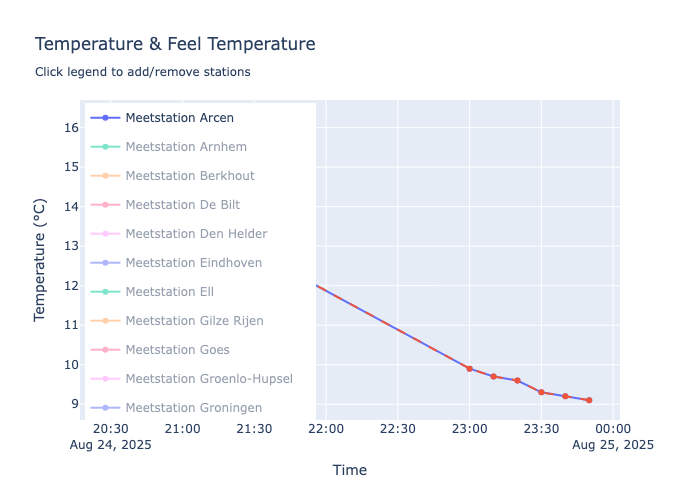

In [57]:
fig = go.Figure()

# Get unique stations
stations = station_measurements_viz_df['stationname'].unique().sort()

for i, station in enumerate(stations):
    station_data = station_measurements_viz_df.filter(pl.col('stationname') == station)
    
    # Add temperature line
    fig.add_trace(go.Scatter(
        x=station_data['timestamp'],
        y=station_data['temperature'],
        name=f'{station}',
        legendgroup=station,
        visible=True if i == 0 else 'legendonly'
    ))
    
    # Add feel temperature as dashed line
    fig.add_trace(go.Scatter(
        x=station_data['timestamp'],
        y=station_data['feeltemperature'],
        name=f'{station} (feel)',
        line=dict(dash='dash'),
        legendgroup=station,
        showlegend=False,  # Hide from legend to avoid clutter
        visible=True if i == 0 else 'legendonly'
    ))

fig.update_layout(
    height=600,
    hovermode='x unified',
    title='Temperature & Feel Temperature<br><sub>Click legend to add/remove stations</sub>',
    yaxis_title='Temperature (°C)',
    xaxis_title='Time',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

if not USER_SETTINGS['user_needs_to_print']:
    pio.renderers.default = "png" 
fig.show()

# In the non-printing version it's interactive

In [58]:
# This is a map of the Netherlands
m = folium.Map(location=[52.3, 5.5], zoom_start=7, tiles='OpenStreetMap')

latest_temps = station_measurements_viz_df.group_by('stationid').agg([
    pl.col('temperature').last().alias('latest_temp'),
    pl.col('lat').first(),
    pl.col('lon').first(),
    pl.col('stationname').first()
]).to_pandas()

# Add markers for each station
for _, row in latest_temps.iterrows():
    temp = row['latest_temp']
    if temp < 15:
        color = 'blue'
    elif temp < 18:
        color = 'green'
    elif temp < 20:
        color = 'orange'
    else:
        color = 'red'
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        popup=f"{row['stationname']}<br>Temp: {temp:.1f}°C",
        tooltip=row['stationname'],
        color=color,
        fillColor=color,
        fillOpacity=0.7
    ).add_to(m)

m

In [59]:
m.save("map.html")

## Question 3

Store the measurements data and the station data in an SQL database. Use .sqlite for the database. Consider using index, Primary Key, and defining the relationship between the two tables.

## Approach to question 3

This question should now be much easier to answer as polars dataframes are lot like SQL tables.

That's why I'm doing this now and not at the beginning.

In [60]:
# The tables are writing themselves, look!
station_measurements_df, stations_df

(shape: (652, 11)
 ┌────────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬──────────┬───────────┐
 │ measuremen ┆ timestamp ┆ temperatu ┆ groundtem ┆ … ┆ humidity ┆ precipita ┆ sunpower ┆ stationid │
 │ tid        ┆ ---       ┆ re        ┆ perature  ┆   ┆ ---      ┆ tion      ┆ ---      ┆ ---       │
 │ ---        ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ f32      ┆ ---       ┆ f32      ┆ i32       │
 │ str        ┆ μs]       ┆ f32       ┆ f32       ┆   ┆          ┆ f32       ┆          ┆           │
 ╞════════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪══════════╪═══════════╡
 │ 215d5b02-4 ┆ 2025-08-2 ┆ 16.200001 ┆ 14.7      ┆ … ┆ 63.0     ┆ 0.0       ┆ 1.0      ┆ 6391      │
 │ 871-40a7-8 ┆ 4         ┆           ┆           ┆   ┆          ┆           ┆          ┆           │
 │ ff0-018142 ┆ 20:30:00  ┆           ┆           ┆   ┆          ┆           ┆          ┆           │
 │ …          ┆           ┆           ┆           ┆   ┆         

In [61]:
# This code gives an error if the database already exists.
db_path = Path.cwd() / "dutch_weather.sqlite"
conn = sqlite3.connect(db_path)

# Create tables with proper foreign key using raw SQL
cursor = conn.cursor()

# Create stations table
cursor.execute("""
    CREATE TABLE stations (
        stationid INTEGER PRIMARY KEY,
        stationname TEXT,
        lat REAL,
        lon REAL,
        regio TEXT
    )
""")

# Create measurements table with foreign key
cursor.execute("""
    CREATE TABLE measurements (
        measurementid TEXT,
        timestamp DATETIME,
        temperature REAL,
        groundtemperature REAL,
        feeltemperature REAL,
        windgusts REAL,
        windspeedBft INTEGER,
        humidity REAL,
        precipitation REAL,
        sunpower REAL,
        stationid INTEGER,
        FOREIGN KEY (stationid) REFERENCES stations(stationid)
    )
""")

# Insert data using Pandas (Polars doesn't have direct executemany)
stations_df.to_pandas().to_sql('stations', conn, if_exists='append', index=False)
station_measurements_df.to_pandas().to_sql('measurements', conn, if_exists='append', index=False)

# Create index
cursor.execute("CREATE INDEX idx_measurements_stationid ON measurements(stationid)")

conn.commit()
conn.close()

print(f"Database saved to: {db_path} with foreign key relationship")

Database saved to: /Users/melvinroest/Randstad/zypp/skilltest-buienradar/dutch_weather.sqlite with foreign key relationship


### Let's create a test query

In [62]:
db_path = Path.cwd() / "dutch_weather.sqlite"
conn = sqlite3.connect(db_path)

# Test query
query = """
SELECT 
    m.timestamp,
    m.temperature,
    s.stationname,
    s.lat,
    s.lon
FROM measurements m
JOIN stations s ON m.stationid = s.stationid
LIMIT 5
"""

measurements_from_db_df = pl.read_database(query, conn)
print(measurements_from_db_df)

# Check table schemas
cursor = conn.cursor()
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table'")
for table in cursor.fetchall():
    print(table[0])

conn.close()

shape: (5, 5)
┌─────────────────────┬─────────────┬────────────────────────┬───────────┬──────┐
│ timestamp           ┆ temperature ┆ stationname            ┆ lat       ┆ lon  │
│ ---                 ┆ ---         ┆ ---                    ┆ ---       ┆ ---  │
│ str                 ┆ f64         ┆ str                    ┆ f64       ┆ f64  │
╞═════════════════════╪═════════════╪════════════════════════╪═══════════╪══════╡
│ 2025-08-24 20:30:00 ┆ 16.200001   ┆ Meetstation Arcen      ┆ 51.5      ┆ 6.2  │
│ 2025-08-24 20:30:00 ┆ 17.1        ┆ Meetstation Arnhem     ┆ 52.07     ┆ 5.88 │
│ 2025-08-24 20:30:00 ┆ 17.1        ┆ Meetstation Berkhout   ┆ 52.650002 ┆ 4.98 │
│ 2025-08-24 20:30:00 ┆ 17.1        ┆ Meetstation De Bilt    ┆ 52.099998 ┆ 5.18 │
│ 2025-08-24 20:30:00 ┆ 16.5        ┆ Meetstation Den Helder ┆ 52.919998 ┆ 4.78 │
└─────────────────────┴─────────────┴────────────────────────┴───────────┴──────┘
CREATE TABLE stations (
        stationid INTEGER PRIMARY KEY,
        stationname T

## Question 4: Create an ERD of the SQL database you created. Tip: you can use draw.io for making the diagram.

Now we can just infer the ERD from the database

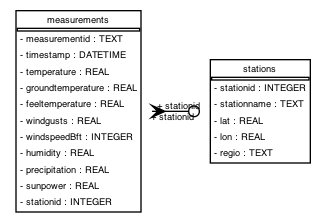

In [63]:
engine = create_engine(f"sqlite:///{db_path}")
metadata = MetaData()
metadata.reflect(bind=engine)

graph = create_schema_graph(
    engine=engine,  # Add this parameter
    metadata=metadata,
    show_datatypes=True,
    show_indexes=True,
    rankdir='LR',
    concentrate=False
)

png_data = graph.create_png()
display(Image('erd.png'))

## Final notes

I started around 20:00. I'm writing this around 23:59. I'm going to rerun this whole notebook.

The script that I initially created has been able to grab some data. Unfortunately, it doesn't have all the 20 minute intervals because I sometimes cancelled it while I was doing something else in the command-line. That's my bad. I mean, ultimately this script shouldn't be running on my computer anyway but somewhere in the cloud.